# CNN in PyTorch

lets import some sample images and explore the concepts of the Cnn

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

In [ ]:
from sklearn.datasets import load_sample_images

sample_images = np.stack(load_sample_images()['images'])
sample_images = torch.tensor(sample_images, dtype=torch.float32) / 255.0


We have two images, both are 427 pixels high and 640 pixels wide, and they have
three color channels: red, green, and blue.  PyTorch expects
the channel dimension to be just before the height and width dimensions, not after, so
we need to permute the dimensions using the permute() method:

In [ ]:
sample_images.shape

In [ ]:
sample_images_permuted = torch.permute(sample_images, (0, 3, 1, 2))
sample_images_permuted.shape

In [ ]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

plt.figure(figsize=(8, 4))
for index, image in enumerate(sample_images_permuted):
    plt.subplot(1, 2, index + 1)
    plot_image(image)

In [ ]:
import torchvision
import torchvision.transforms.v2 as T
cropped_images = T.CenterCrop((70,120))(sample_images_permuted)
cropped_images.shape

Now let’s create a 2D convolutional layer and feed it these cropped images to see
what comes out. For this, PyTorch provides the nn.Conv2d layer.

Under the hood, this
layer relies on the `torch.nn.((("torch", "F.conv2d()")))functional.conv2d()`
function. Let’s create a convolutional layer with 32 filters, each of size 7 × 7 (using
kernel_size=7

In [ ]:
import torch.nn as nn

torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7, 7),padding='same')
fmaps = conv_layer(cropped_images)

In [ ]:
fmaps.shape

In [ ]:
conv_layer.weight.shape

In [ ]:
conv_layer.bias.shape

## Implementing Pooling Layers with PyTorch

In [ ]:
max_pool = nn.MaxPool2d(kernel_size=2)

In [ ]:
output_max = max_pool(cropped_images)
output_max.shape

In [ ]:

avg_pool = nn.AvgPool2d(kernel_size=2)

In [ ]:

output_avg = avg_pool(cropped_images)
output_avg.shape

In [ ]:

fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
ax1.imshow(cropped_images[0].permute(1, 2, 0))
ax1.axis('off')
ax1.set_title("Original image")

ax2 = plt.subplot2grid((2, 3), (0, 2))
ax2.imshow(output_max[0].permute(1, 2, 0))
ax2.axis('off')
ax2.set_title("Max pooling")

ax3 = plt.subplot2grid((2, 3), (1, 2))
ax3.imshow(output_avg[0].permute(1, 2, 0))
ax3.axis('off')
ax3.set_title("Avg pooling")

plt.tight_layout()
plt.show()


Depth - wise pooling layer

In [ ]:
import torch.nn.functional as F

class DepthPool(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        Z = inputs.view(batch, channels, height * width)  # merge spatial dims
        Z = Z.permute(0, 2, 1)  # switch spatial and channels dims
        Z = F.max_pool1d(Z, kernel_size=self.kernel_size, stride=self.stride,
                                        padding=self.padding)  # compute max pool
        Z = Z.permute(0, 2, 1)  # switch back spatial and channels dims
        return Z.view(batch, -1, height, width)  # unmerge spatial dims

Global average pooling layer

In [ ]:
global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
output = global_avg_pool(cropped_images)

# CNN Architectures

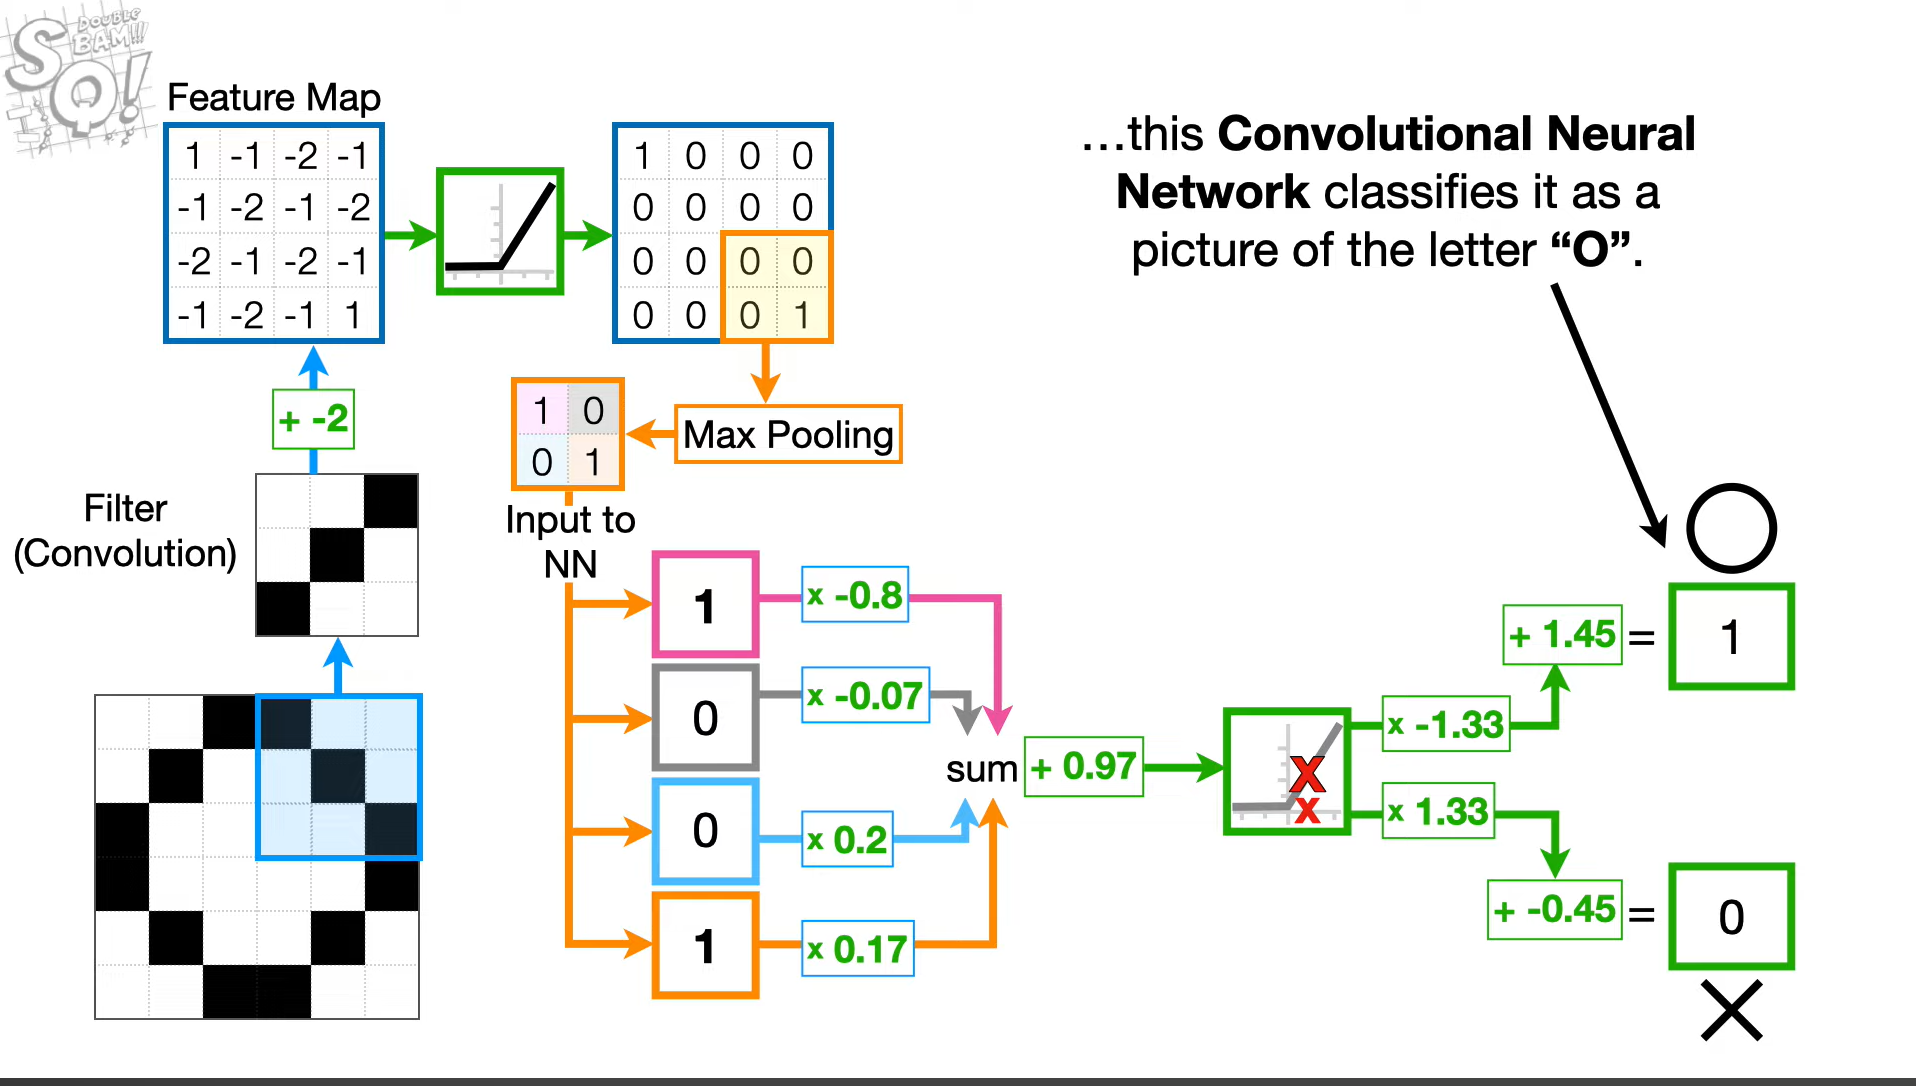

In [ ]:
from functools import partial

torch.manual_seed(42)

DefaultConv2d = partial(nn.Conv2d, kernel_size=3, padding="same")
model = nn.Sequential(
            DefaultConv2d(in_channels=1, out_channels=64, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            DefaultConv2d(in_channels=64, out_channels=128),
            nn.ReLU(),
            DefaultConv2d(in_channels=128, out_channels=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            DefaultConv2d(in_channels=128, out_channels=256),
            nn.ReLU(),
            DefaultConv2d(in_channels=256, out_channels=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=64, out_features=10),
)

In [ ]:
!pip install torchmetrics

In [ ]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [ ]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
n_epochs = 20
optimizer = torch.optim.AdamW(model.parameters())
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs).to(device)

### LeNet-5 Archictures

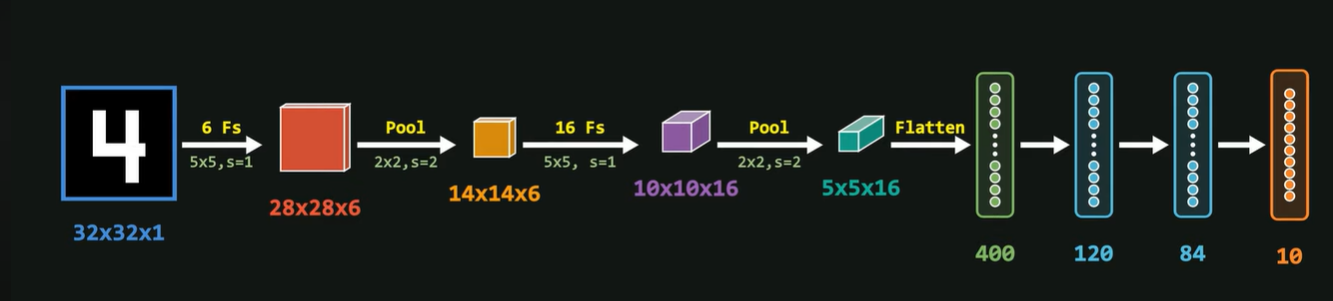

# Using TorchVision's Pretrained Models

For example, you can load a ConvNeXt model pretrained on ImageNet with the
following code. There are several variants of the ConvNeXt model—tiny, small, base,
and large—and this code loads the base variant

In [ ]:
weights = torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1
model = torchvision.models.convnext_base(weights=weights).to(device)

In [ ]:
transforms = weights.transforms()
preprocessed_images = transforms(sample_images_permuted)

In [ ]:
model.eval()
with torch.no_grad():
    y_logits = model(preprocessed_images.to(device))

In [ ]:
transforms

In [ ]:
preprocessed_images

In [ ]:

y_pred = torch.argmax(y_logits, dim=1)
y_pred

In [ ]:
class_names = weights.meta["categories"]
class_names[698]

In [ ]:
class_names[985]

In [ ]:
y_top3_logits, y_top3_class_ids = y_logits.topk(k=3, dim=1)
[[class_names[class_id] for class_id in top3] for top3 in y_top3_class_ids]

In [ ]:
y_top3_logits.softmax(dim=1)

# Pretrained Models for Transfer Learning


 we will reuse the ConvNeXt
model we loaded earlier—which was pretrained on ImageNet—and after replacing
its classification head, we will fine-tune it on the 102 Category Flower Dataset29

(Flowers102 for short). This dataset only contains 10 images per class, and there
are 102 classes in total (as the name indicates), so if you try to train a model from
scratch, you will really struggle to get high accuracy. However, it’s quite easy to get
over 90% accuracy using a good pretrained model. Let’s see how. First, let’s download
the dataset using Torchvision

In [ ]:
DefaultFlowers102 = partial(torchvision.datasets.Flowers102,root="datasets",
                          transform=weights.transforms(),download=True)

train_set = DefaultFlowers102(split='train')
valid_set = DefaultFlowers102(split='val')
test_set = DefaultFlowers102(split='test')

now we create an dataloader for the pipline  

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [ ]:
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(500),
])
flowers_to_display = DefaultFlowers102(split="train", transform=transform)
sample_flowers = sorted({y: img for img, y in flowers_to_display}.items())[:12]

plt.figure(figsize=(10, 6))
for class_id, image in sample_flowers:
    if class_id == 12: break
    plt.subplot(3, 4, class_id + 1)
    plot_image(image)
    plt.title(f"{class_id}: {class_names[class_id]}", fontsize=11)

plt.show()

In [ ]:
[ name for name,child in model.named_children() ]

In [ ]:
model.classifier

the upper layer of the model gets 1024 input and output of an 1000 so we need to replace the output for the 102 class rather than 1000 

In [ ]:
n_classes = 102
model.classifier[2] = nn.Linear(1024, n_classes).to(device)

 it’s usually a good idea to freeze the weights of the
pretrained layers, at least at the beginning of training. We can do this by freezing
every single parameter in the model, and then unfreezing only the parameters of the
head

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
n_epochs = 5
optimizer = torch.optim.AdamW(model.parameters())
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass",
                                 num_classes=102).to(device)
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)